# Clustering to define UK Systems
A key part of out analysis is defining our units of analysis within the UK street network, our cities.

To do so we will use clustering to define cities for analysis. 

In [3]:
# load relevant packages for analysis
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import igraph
import graph_tool.all as gt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import shapely.wkt
import statsmodels.api as sm
import sys
from xml import etree

# A. Read in Graph and Check Nodes & Edges

In [ ]:
# simple graph for faster tetsing
G_simple = nx.read_graph('Data/G_simple.graphml')

In [2]:
# load graph & check
G_percolation = nx.read_graphml('Data/G_percolation.graphml')

NameError: name 'nx' is not defined

In [9]:
print(f"Number of nodes: {G_percolation.number_of_nodes()}")
print(f"Number of edges: {G_percolation.number_of_edges()}")

Number of nodes: 3295455
Number of edges: 3854671


In [8]:
list(G_percolation.edges(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 'D3B5B123-54B7-467E-8C60-BE2383A3624B',
 {'length': 179.0,
  'road_classification': 'Unknown',
  'road_function': 'Restricted Local Access Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)',
  'occupation_probability': 0.00927614779300641})

In [9]:
list(G_percolation.nodes(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 {'pos': '(187422.39, 887423.74)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (187422.39 887423.74)',
  'angle': 126.44988586701946,
  'occupation_probability': 0.7024993659278859})

In [6]:
print(f"Number of nodes: {G_simple.number_of_nodes()}")
print(f"Number of edges: {G_simple.number_of_edges()}")

Number of nodes: 1685538
Number of edges: 1896546


In [10]:
list(G_simple.edges(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 'D3B5B123-54B7-467E-8C60-BE2383A3624B',
 {'length': 179.0,
  'road_classification': 'Unknown',
  'road_function': 'Restricted Local Access Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)'})

In [11]:
list(G_simple.nodes(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 {'pos': '(187422.39, 887423.74)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (187422.39 887423.74)'})

# B. Conduct Clustering in the Place of Percolation
To define the systems within the UK we will conduct a percolation process by removing edges based on their length.

This gradually disconnects the network, resulting in smaller, highly connected clusters. This represents connected communities or regions. This make percolation a useful tool to define systems at different scales.

In Arcaute et al. 2016, they have found that cities can be identified using a percolation process with a distance threshold of 300 meters, as this distance accurately captures the complexity and boundaries of urban systems.

### 1. Clustering to Identify 'Urbanised Areas' in UK

In [3]:
# minimum cluster size of 600 intersections
# init a new graph for clusters
G_300m = nx.Graph()

# add edges & nodes to new graph using d=300m
for u, v, data in G_percolation.edges(data=True):
    if data['length'] <= 300:
        if not G_300m.has_node(u):
            G_300m.add_node(u, **G_percolation.nodes[u])
        if not G_300m.has_node(v):
            G_300m.add_node(v, **G_percolation.nodes[v])
        G_300m.add_edge(u, v, **data)

# save new graph
nx.write_graphml(G_300m, "Data/G_300m.graphml")

# filter clusters by size
clusters_600 = [c for c in nx.connected_components(G_300m) if len(c) > 600]
print(f"Number of clusters (cities) identified: {len(clusters_600)}")

Number of clusters (cities) identified: 533


In [10]:
# minimum cluster size of 190 intersections
# filter clusters by size
clusters_190 = [c for c in nx.connected_components(G_300m) if len(c) > 190]
print(f"Number of clusters (cities) identified: {len(clusters_190)}")

Number of clusters (cities) identified: 1483


In [4]:
G_300m = nx.read_graphml('Data/G_300m.graphml')

In [5]:
print(f"Number of nodes: {G_300m.number_of_nodes()}")
print(f"Number of edges: {G_300m.number_of_edges()}")

Number of nodes: 3161041
Number of edges: 3448220


# C. Plotting Clusters at different Scales

### G_percolation, d=300m, miniumum cluster size = 190 intersections

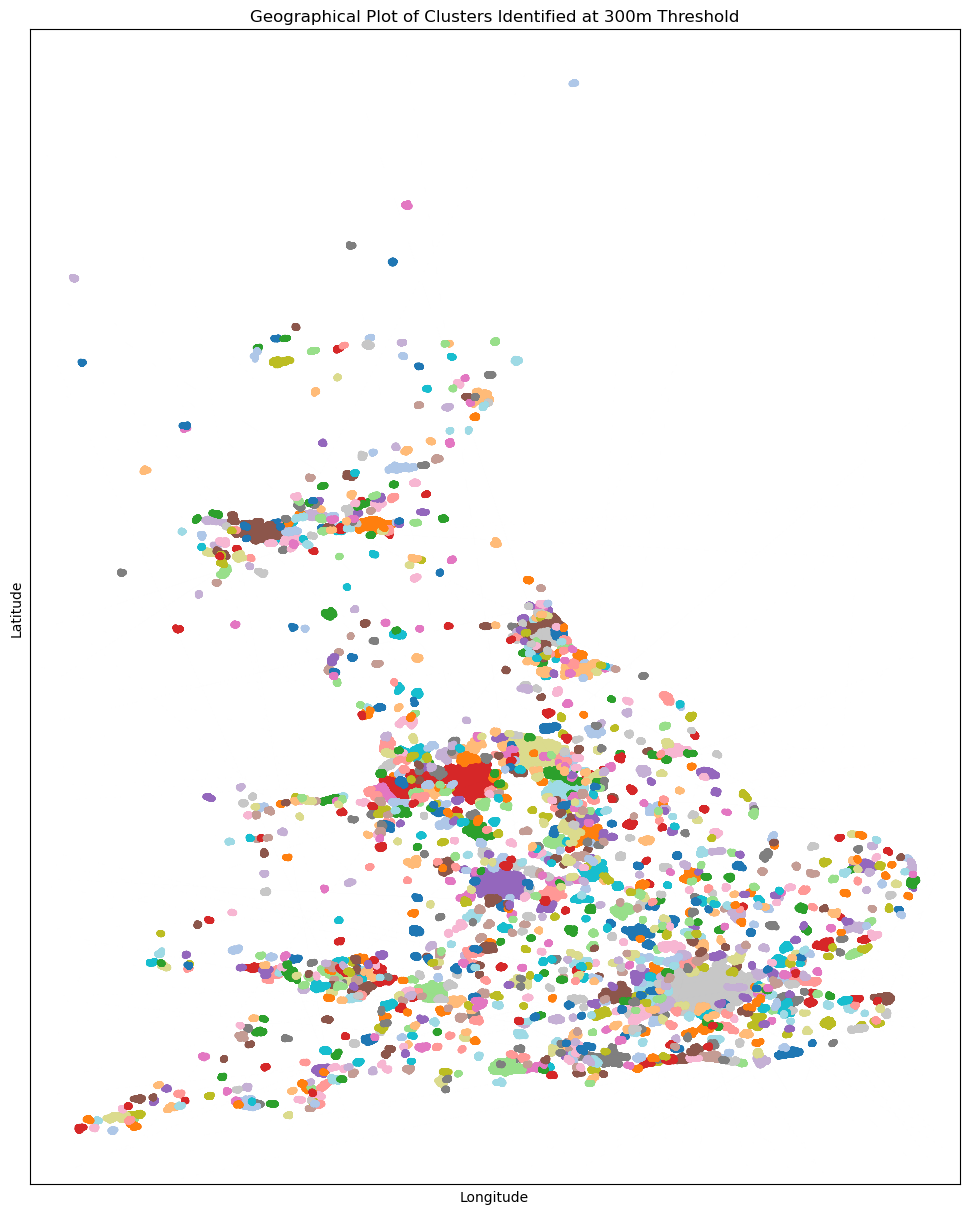

In [5]:
# G_percolation, d=300m, miniumum cluster size = 190 intersections
color_map = plt.cm.tab20.colors

# dictioanry for plotting 'pos'
pos = {node: tuple(map(float, data['pos'].strip('()').split(', '))) for node, data in G_300m.nodes(data=True)}

# plot
plt.figure(figsize=(20, 30))

for i, clusters_190 in enumerate(clusters_190):
    cluster_subgraph = G_300m.subgraph(clusters_190)
    node_color = color_map[i % len(color_map)]
    
    # plot nodes
    nx.draw_networkx_nodes(cluster_subgraph, pos, node_size=10, node_color=[node_color] * len(clusters_190))
    
    # plot edges using LINESTRING
    for u, v, data in cluster_subgraph.edges(data=True):
        line = LineString([tuple(map(float, coord.split())) for coord in data['geometry'].strip('LINESTRING ()').split(', ')])
        x, y = line.xy
        plt.plot(x, y, color=node_color, linewidth=1)

plt.title("Geographical Plot of Clusters Identified at 300m Threshold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# G_percolation, d=300m, miniumum cluster size = 600 intersections
color_map = plt.cm.tab20.colors

# dictioanry for plotting 'pos'
pos = {node: tuple(map(float, data['pos'].strip('()').split(', '))) for node, data in G_300m.nodes(data=True)}

# plot
plt.figure(figsize=(20, 30))

for i, clusters_600 in enumerate(clusters_600m):
    cluster_subgraph = G_300m.subgraph(clusters_600m)
    node_color = color_map[i % len(color_map)]

    # plot nodes
    nx.draw_networkx_nodes(cluster_subgraph, pos, node_size=10, node_color=[node_color] * len(clusters_600m))
    
    # plot edges using LINESTRING
    for u, v, data in cluster_subgraph.edges(data=True):
        line = LineString([tuple(map(float, coord.split())) for coord in data['geometry'].strip('LINESTRING ()').split(', ')])
        x, y = line.xy
        plt.plot(x, y, color=node_color, linewidth=1)

plt.title("Geographical Plot of Clusters Identified at 300m Threshold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### G_simple, d=300m, miniumum cluster size = 600 intersections

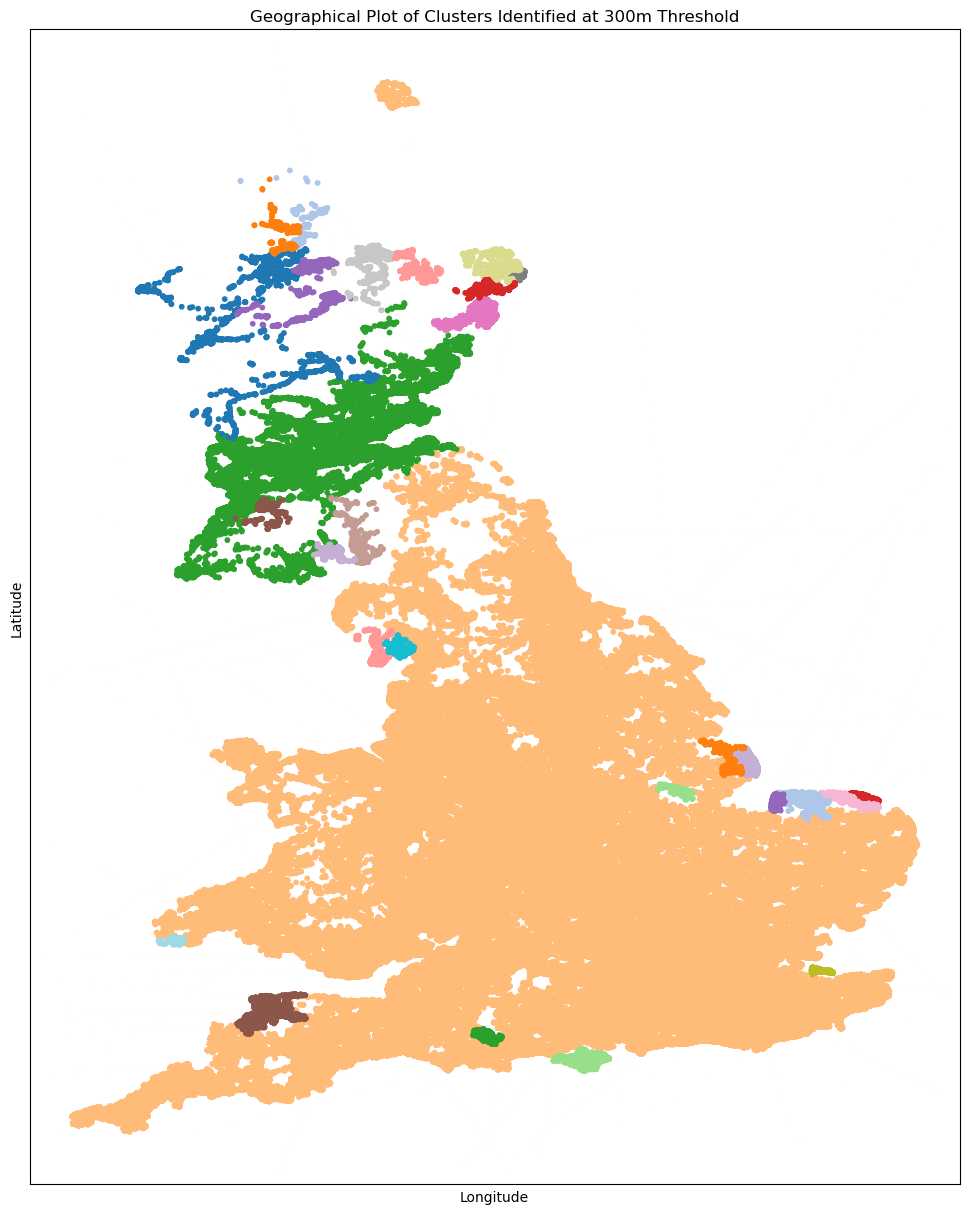

In [6]:
# G_simple, d=300m, miniumum cluster size = 600 intersections
color_map = plt.cm.tab20.colors

# dictioanry for plotting 'pos'
pos = {node: tuple(map(float, data['pos'].strip('()').split(', '))) for node, data in G_300m.nodes(data=True)}

# plot
plt.figure(figsize=(12, 15))

for i, cluster in enumerate(clusters):
    cluster_subgraph = G_300m.subgraph(cluster)
    node_color = color_map[i % len(color_map)]
    
    # draw nodes
    nx.draw_networkx_nodes(cluster_subgraph, pos, node_size=10, node_color=[node_color] * len(cluster))
    
    # draw edges with LINESTRING geometries
    for u, v, data in cluster_subgraph.edges(data=True):
        line = LineString([tuple(map(float, coord.split())) for coord in data['geometry'].strip('LINESTRING ()').split(', ')])
        x, y = line.xy
        plt.plot(x, y, color=node_color, linewidth=1)

plt.title("Geographical Plot of Clusters Identified at 300m Threshold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# D. Choose our Systems for Analysis (2 Options)

In the previous section we identified *533* systems using the following metrics:
1. A minimum road segment length of d=300m
2. A miniumum cluster size = 600 intersections

The next stage in our analysis intends to assess the spatial hierarchy of these clusters. This will allows us to assign a betweeness centrality score to each road segment in our network. However processing 533 different clusters is not only computationally intensive, but may not neccessarily yield a richer conclusion. In simpler terms, the conputational intensity endured will not neccessarily yield better results.

Here, we ponder two potential method to reduce the number of clusters needed for analysis:
1. **Cluster Size**: Larger clusters are likely to represent more significant urban areas. By focusing on the size, you can ensure that the urban areas you select are substantial enough to warrant detailed analysis.

2. **Average Clustering Coefficient**: This metric measures the degree to which nodes in a graph tend to cluster together. A higher average clustering coefficient indicates a higher local density, which can help identify well-connected and coherent urban areas.

# E. Grouping Clusters Based on their Nature

We have now clustered our data into the systems we will use for our analysis. We will now categorise these cluster into relevant scales.

NetworkX as a package experiences severe difficulty processing larger graphs. Thus we use *graph_tool* a library far faster due to its optimised C++ backend. This code is written below.

In [4]:
import graph_tool.all as gt

In [5]:
# convert nx graph to graph-tool
def nx_to_gt(nx_graph):
    gt_graph = gt.Graph(directed=False)
    nx_to_gt_map = {}
    
    for node in nx_graph.nodes:
        nx_to_gt_map[node] = gt_graph.add_vertex()
    
    for edge in nx_graph.edges:
        gt_graph.add_edge(nx_to_gt_map[edge[0]], nx_to_gt_map[edge[1]])
    
    return gt_graph

## E1. Filter Clusters by Size and Create Subgraphs for Each Cluster

In [6]:
# uncomment if starting analysis from here
G_300m = nx.read_graphml('Data/G_300m.graphml')
# minimum cluster size of 190 intersections
# filter clusters by size
clusters_190 = [c for c in nx.connected_components(G_300m) if len(c) > 190]
print(f"Number of clusters (cities) identified: {len(clusters_190)}")

Number of clusters (cities) identified: 1483


## E2. Calculate Diameter & Metrics for Each Cluster Using graph-tool

In [7]:
# calc. the diameter using graph-tool
def calculate_diameter(gt_graph):
    return gt.pseudo_diameter(gt_graph)[0]

# score for each cluster
cluster_scores = []

for idx, cluster in enumerate(clusters_190):
    print(f"Processing cluster {idx+1}/{len(clusters_190)}")  # progress logging
    
    # subgraph from nodes in the cluster
    cluster_subgraph = G_300m.subgraph(cluster).copy()
    
    # to graph-tool graph
    gt_cluster_subgraph = nx_to_gt(cluster_subgraph)
    
    # diameter
    diameter = calculate_diameter(gt_cluster_subgraph)
    
    # node count
    node_count = len(cluster_subgraph)
    
    # diameter / node count calculation
    score = diameter / node_count if node_count > 0 else 0
    
    cluster_scores.append({
        'cluster': cluster,
        'diameter': diameter,
        'node_count': node_count,
        'score': score
    })

Processing cluster 1/1483
Processing cluster 2/1483
Processing cluster 3/1483
Processing cluster 4/1483
Processing cluster 5/1483
Processing cluster 6/1483
Processing cluster 7/1483
Processing cluster 8/1483
Processing cluster 9/1483
Processing cluster 10/1483
Processing cluster 11/1483
Processing cluster 12/1483
Processing cluster 13/1483
Processing cluster 14/1483
Processing cluster 15/1483
Processing cluster 16/1483
Processing cluster 17/1483
Processing cluster 18/1483
Processing cluster 19/1483
Processing cluster 20/1483
Processing cluster 21/1483
Processing cluster 22/1483
Processing cluster 23/1483
Processing cluster 24/1483
Processing cluster 25/1483
Processing cluster 26/1483
Processing cluster 27/1483
Processing cluster 28/1483
Processing cluster 29/1483
Processing cluster 30/1483
Processing cluster 31/1483
Processing cluster 32/1483
Processing cluster 33/1483
Processing cluster 34/1483
Processing cluster 35/1483
Processing cluster 36/1483
Processing cluster 37/1483
Processing

In [8]:
# sorted clusters x score (diameter/node count)
sorted_clusters = sorted(cluster_scores, key=lambda x: x['score'], reverse=True)
print('Clusters Sorted based on Diameter / Node Count')

# convert to df and ensure calculations are correct
sorted_clusters_df = pd.DataFrame(sorted_clusters)

Clusters Sorted based on Diameter / Node Count


In [9]:
#.head() to inspect df
sorted_clusters_df.head()

,cluster,diameter,node_count,score
0,"{10A6ECD9-E25C-4786-9FAC-C72614ECB287, B1995FD...",62.0,196,0.316327
1,"{5E7C74F0-D0EF-4A8A-AF90-EE18D18C8423, 762DECF...",73.0,246,0.296748
2,"{66E39740-ECC1-4D8A-801A-024400C02EF9, B61B1DD...",61.0,216,0.282407
3,"{8DD9B8DD-688F-4AF8-AAFD-0C183C328016, 8F2C7A9...",58.0,208,0.278846
4,"{04E51D5C-AF45-45A3-8A7A-88C51F056B22, 30C36F4...",58.0,211,0.274882


In [10]:
# .info() to inspect df
sorted_clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cluster     1483 non-null   object 
 1   diameter    1483 non-null   float64
 2   node_count  1483 non-null   int64  
 3   score       1483 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 46.5+ KB


In [11]:
# save sorted clusters df as a csv
# sorted_clusters_df.to_csv('Data/sorted_clusters.csv', index=False)

In [13]:
import os
os.getcwd()

'/Users/nikhildesai/Documents/UCLT2/Dissertation/Multiscale_Centrality'

In [18]:
sorted_clusters_df = pd.read_csv('Data/sorted_clusters.csv')

In [15]:
# round to 2 decimals
sorted_clusters_df['score'] = sorted_clusters_df['score'].round(2)

# descriptive stats
descriptive_stats = sorted_clusters_df.describe()
print(descriptive_stats)

          diameter     node_count        score
count  1483.000000    1483.000000  1483.000000
mean     74.117330    1373.412677     0.122097
std      71.152663    6927.477032     0.050454
min      24.000000     191.000000     0.010000
25%      42.000000     266.000000     0.090000
50%      54.000000     429.000000     0.120000
75%      79.000000     853.500000     0.160000
max    1311.000000  188635.000000     0.320000


## E3. Plots of Unstandardised DF

#### Diameter:
Count: 1483 urban systems.
Mean: The average diameter is 74.11. This suggests that, on average, the longest shortest path within these urban systems is about 74 units (this could be in terms of intersections or other relevant units).
Standard Deviation (std): 71.15. There is significant variability in the diameter of these urban systems.
Minimum (min): The smallest diameter is 23.
25th Percentile (25%): 25% of the urban systems have a diameter less than or equal to 42.
Median (50%): The median diameter is 54, indicating that half of the urban systems have a diameter less than or equal to 54 and the other half have a diameter greater than 54.
75th Percentile (75%): 75% of the urban systems have a diameter less than or equal to 79.
Maximum (max): The largest diameter is 1311, showing the presence of some very large urban systems.

#### Node Count:
Count: 1483 urban systems.
Mean: The average node count is 1373.41. On average, there are about 1373 intersections or nodes in these urban systems.
Standard Deviation (std): 6927.48. There is extremely high variability in the number of nodes, indicating the presence of both very small and very large urban systems.
Minimum (min): The smallest urban system has 191 nodes.
25th Percentile (25%): 25% of the urban systems have 266 nodes or fewer.
Median (50%): The median node count is 429, indicating that half of the urban systems have 429 nodes or fewer.
75th Percentile (75%): 75% of the urban systems have 853.5 nodes or fewer.
Maximum (max): The largest urban system has 188,635 nodes, indicating the presence of some very large and complex urban systems.

#### Score (Diameter/Node Count):
Count: 1483 urban systems.
Mean: The average score is 0.12209. This score represents the average ratio of the diameter to the node count, giving a sense of the efficiency or spread of the urban systems.
Standard Deviation (std): 0.05047. There is moderate variability in the scores.
Minimum (min): The smallest score is 0.01, indicating very efficient or compact urban systems.
25th Percentile (25%): 25% of the urban systems have a score of 0.085 or lower.
Median (50%): The median score is 0.12, indicating that half of the urban systems have a score of 0.12 or lower.
75th Percentile (75%): 75% of the urban systems have a score of 0.16 or lower.
Maximum (max): The highest score is 0.32, indicating some urban systems are less efficient or more spread out.

#### Interpretation:
Diameter: The data shows a wide range of diameters, with most urban systems having diameters between 23 and 1311. The high standard deviation suggests that while many urban systems have moderate diameters, some are exceptionally large.

Node Count: There is a considerable range in the number of nodes across urban systems, from very small systems with just 191 nodes to very large systems with up to 188,635 nodes. The large standard deviation indicates that most urban systems have a moderate number of nodes, but a few systems are extremely large.

Score: The scores provide an indication of the relative compactness or spread of the urban systems. The scores range from 0.01 to 0.32, with most systems falling between 0.085 and 0.16. A higher score suggests a more spread-out urban system relative to its size, while a lower score indicates a more compact system.

#### Categorization:
Based on the score, urban systems can be categorized into different types:

Compact Systems: Scores closer to the minimum (0.01).
Moderately Compact Systems: Scores around the median (0.12).
Spread-Out Systems: Scores closer to the maximum (0.32).
These categories can help in understanding the nature of different urban systems and planning accordingly.

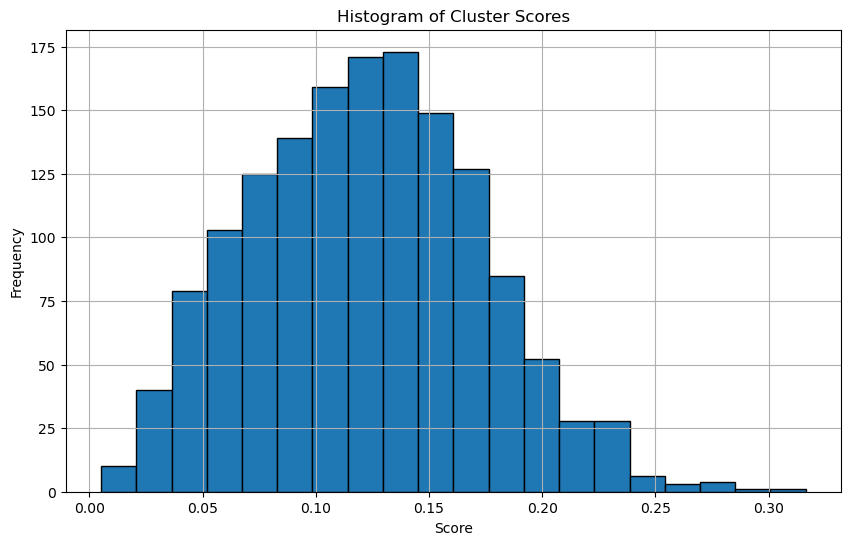

In [19]:
# histogram of scores
plt.figure(figsize=(10, 6))
plt.hist(sorted_clusters_df['score'], bins=20, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Scores')
plt.grid(True)
plt.show()

          diameter     node_count       score
count  1483.000000    1483.000000  1483.00000
mean     74.113958    1373.412677     0.12209
std      71.153840    6927.477032     0.05047
min      23.000000     191.000000     0.01000
25%      42.000000     266.000000     0.08500
50%      54.000000     429.000000     0.12000
75%      79.000000     853.500000     0.16000
max    1311.000000  188635.000000     0.32000


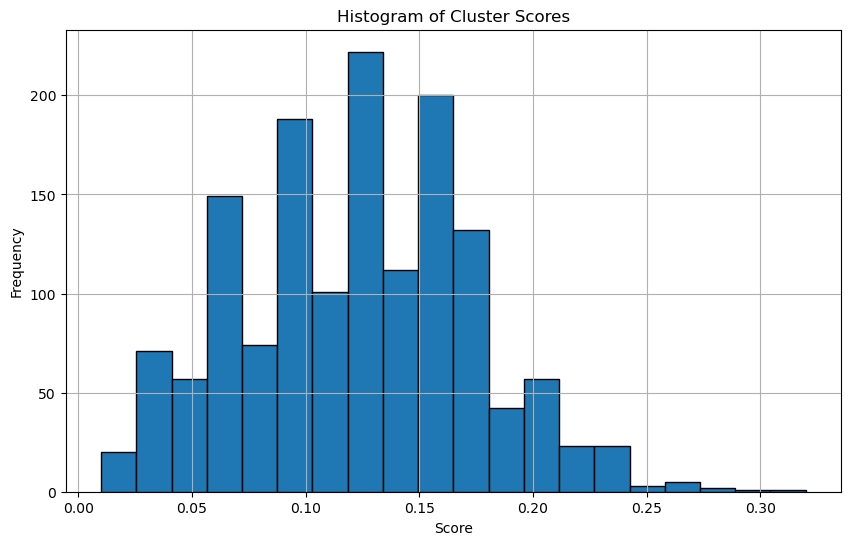

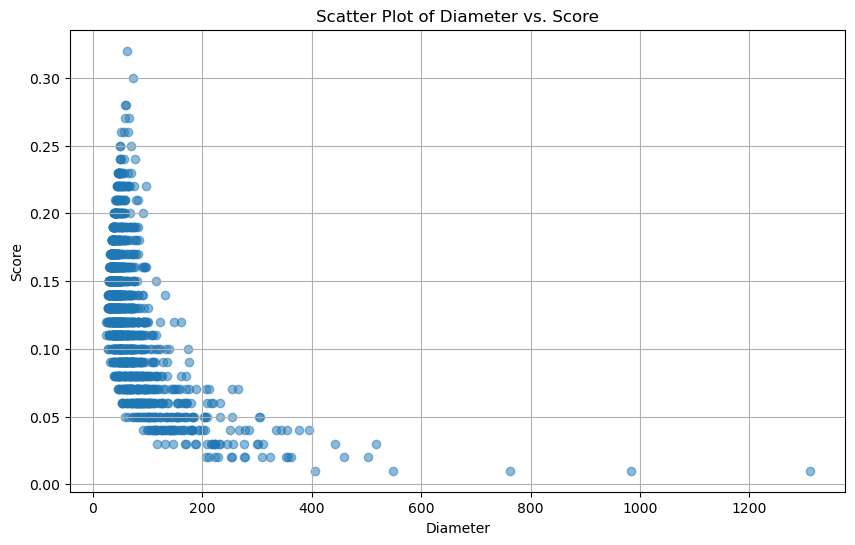

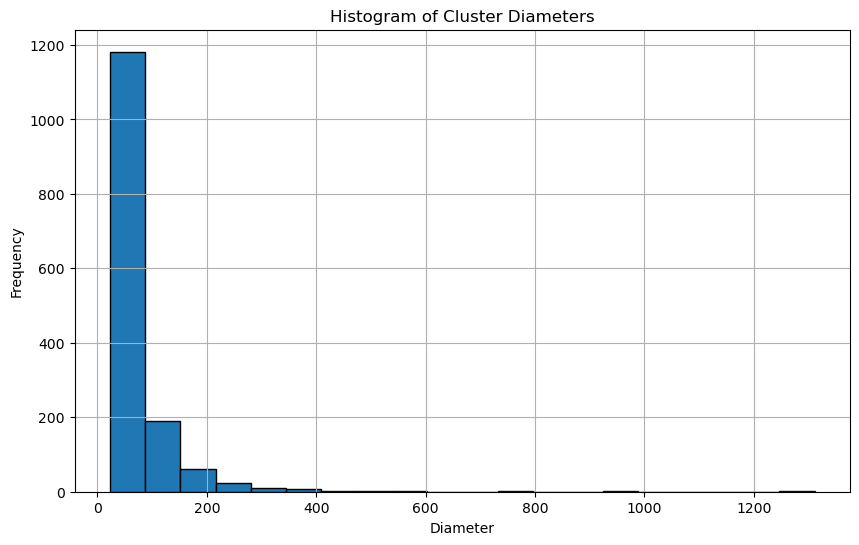

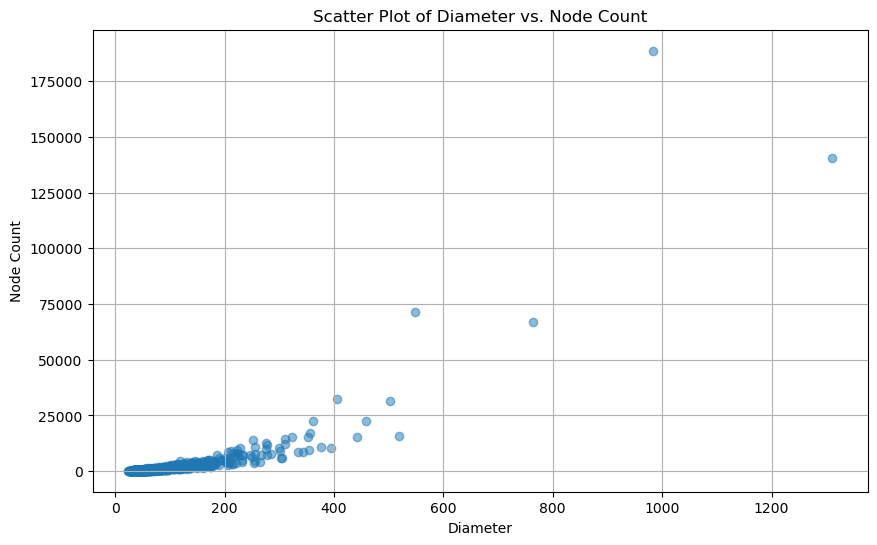

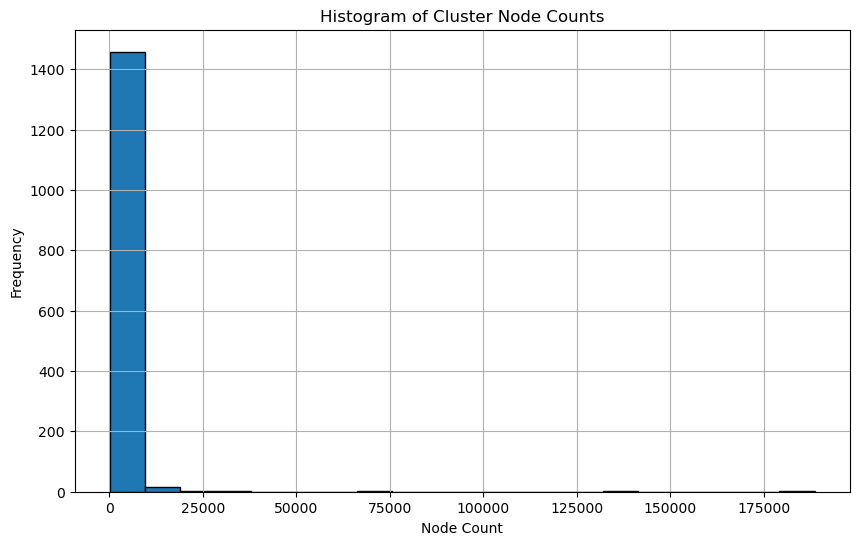

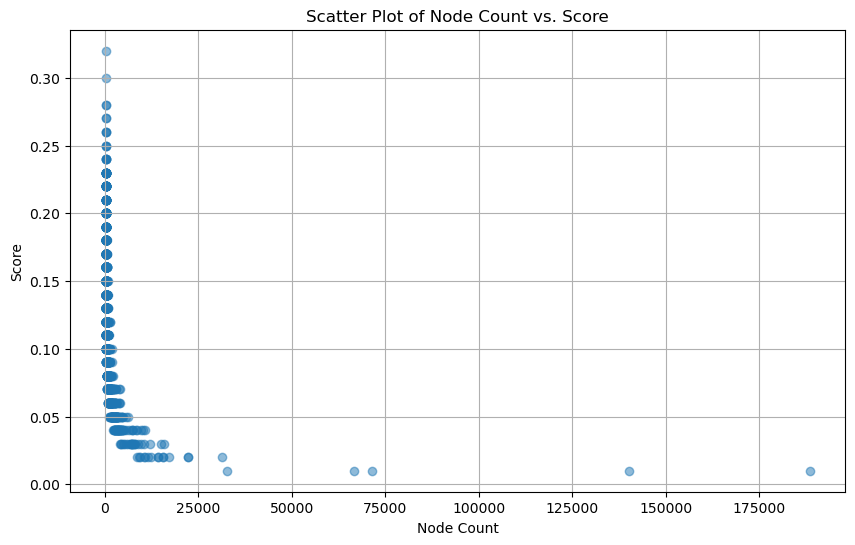

In [21]:
# histogram of scores
plt.figure(figsize=(10, 6))
plt.hist(sorted_clusters_df['score'], bins=20, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Scores')
plt.grid(True)
plt.show()

# scatter of diameter vs. score
plt.figure(figsize=(10, 6))
plt.scatter(sorted_clusters_df['diameter'], sorted_clusters_df['score'], alpha=0.5)
plt.xlabel('Diameter')
plt.ylabel('Score')
plt.title('Scatter Plot of Diameter vs. Score')
plt.grid(True)
plt.show()

# histogram of diameters
plt.figure(figsize=(10, 6))
plt.hist(sorted_clusters_df['diameter'], bins=20, edgecolor='black')
plt.xlabel('Diameter')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Diameters')
plt.grid(True)
plt.show()

# scatter of diameter vs. node_count
plt.figure(figsize=(10, 6))
plt.scatter(sorted_clusters_df['diameter'], sorted_clusters_df['node_count'], alpha=0.5)
plt.xlabel('Diameter')
plt.ylabel('Node Count')
plt.title('Scatter Plot of Diameter vs. Node Count')
plt.grid(True)
plt.show()

# histogram of node counts
plt.figure(figsize=(10, 6))
plt.hist(sorted_clusters_df['node_count'], bins=20, edgecolor='black')
plt.xlabel('Node Count')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Node Counts')
plt.grid(True)
plt.show()

# scatter: node_count vs. score
plt.figure(figsize=(10, 6))
plt.scatter(sorted_clusters_df['node_count'], sorted_clusters_df['score'], alpha=0.5)
plt.xlabel('Node Count')
plt.ylabel('Score')
plt.title('Scatter Plot of Node Count vs. Score')
plt.grid(True)
plt.show()

### Identifying London:
London, being a major city, is expected to have:

- A high node count due to its large size and complexity.
- A large diameter because of its extensive urban spread.
- A relatively lower score (diameter/node count) indicating a dense urban system, but this can vary.

### Insights on Urban Systems in the UK:
#### High Variability:

- The high standard deviation in both diameter and node count indicates significant variability in the size and complexity of urban systems across the UK.
- Urban systems range from small towns with a few hundred nodes to large cities with tens of thousands of nodes.

#### Compact vs. Spread-Out Systems:

- The score helps in understanding how compact or spread-out an urban system is. Systems with lower scores are more compact, while higher scores indicate more spread-out systems.
- Most urban systems have a score between 0.085 and 0.16, suggesting a mix of moderately compact and moderately spread-out systems.

#### Large Urban Systems:

- The maximum node count of 188,635 and the maximum diameter of 1311 likely correspond to London or other large metropolitan areas.
- These large urban systems are characterized by extensive infrastructure and significant urban sprawl.

#### Median Values:

- The median node count of 429 and the median diameter of 54 suggest that a typical urban system in the UK is relatively small to medium-sized.
- These typical systems are likely towns or small cities.

#### Density and Efficiency:

- The average score of 0.12209 indicates that on average, UK urban systems have a balanced ratio of diameter to node count.
- This average score suggests that while there is some spread, the urban systems are not excessively spread out, maintaining a level of compactness.

### Insights for Urban Planning:
#### Infrastructure Needs:

- Large urban systems like London require extensive infrastructure planning to handle their complexity and size.
- Transportation, utilities, and services must be scaled appropriately.

#### Urban Sprawl Management:

- The significant variability in urban systems suggests a need for tailored approaches in managing urban sprawl.
- Policies could focus on promoting compact urban growth to improve efficiency and reduce environmental impact.

#### Resource Allocation:

- Smaller urban systems may need different resource allocation compared to larger ones.
- Urban planning must consider the unique needs of different sizes and types of urban systems.

By analysing and interpreting this data, urban planners and policymakers can make informed decisions to improve the efficiency, livability, and sustainability of urban systems across the UK.

## E4. Plots of Standardised DF

In [13]:
q_low = 0.05
q_high = 0.95

score_low, score_high = sorted_clusters_df['score'].quantile([q_low, q_high])
diameter_low, diameter_high = sorted_clusters_df['diameter'].quantile([q_low, q_high])
node_count_low, node_count_high = sorted_clusters_df['node_count'].quantile([q_low, q_high])

# Filter the DataFrame to remove the top and bottom 10% of values for each column
filtered_df = sorted_clusters_df[
    (sorted_clusters_df['score'] >= score_low) & (sorted_clusters_df['score'] <= score_high) &
    (sorted_clusters_df['diameter'] >= diameter_low) & (sorted_clusters_df['diameter'] <= diameter_high) &
    (sorted_clusters_df['node_count'] >= node_count_low) & (sorted_clusters_df['node_count'] <= node_count_high)
]

# Print the descriptive statistics of the filtered data
filtered_descriptive_stats = filtered_df.describe()
print(filtered_descriptive_stats)

          diameter   node_count        score
count  1196.000000  1196.000000  1196.000000
mean     63.865385   685.573579     0.119882
std      28.732256   610.978106     0.040211
min      33.000000   203.000000     0.040621
25%      43.000000   301.000000     0.088370
50%      55.000000   453.000000     0.119982
75%      75.000000   801.250000     0.150882
max     180.000000  3793.000000     0.205674


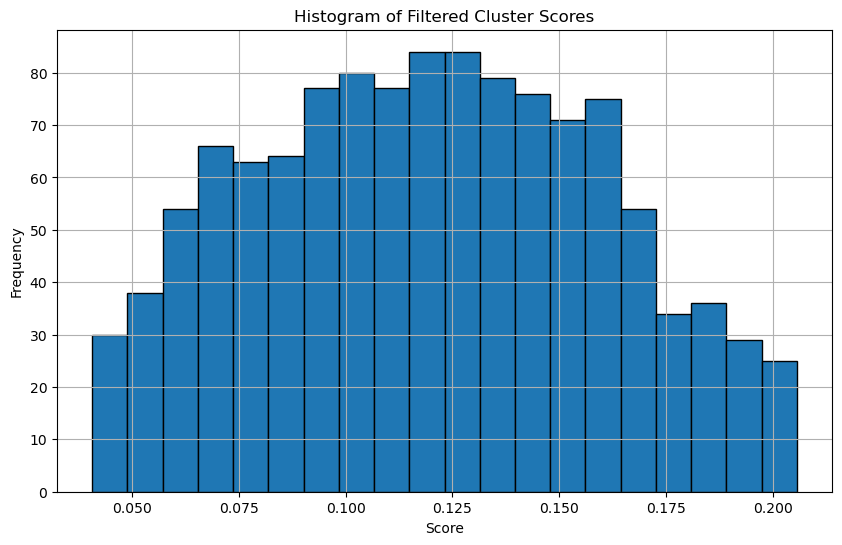

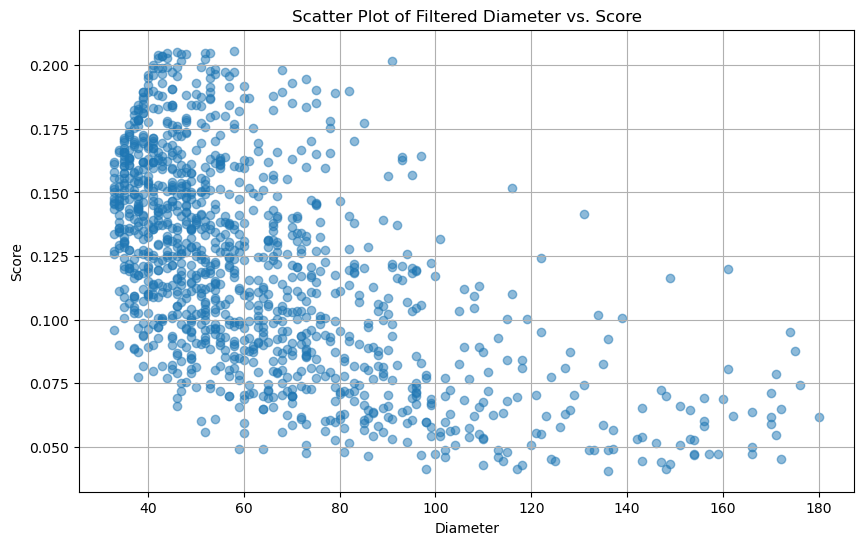

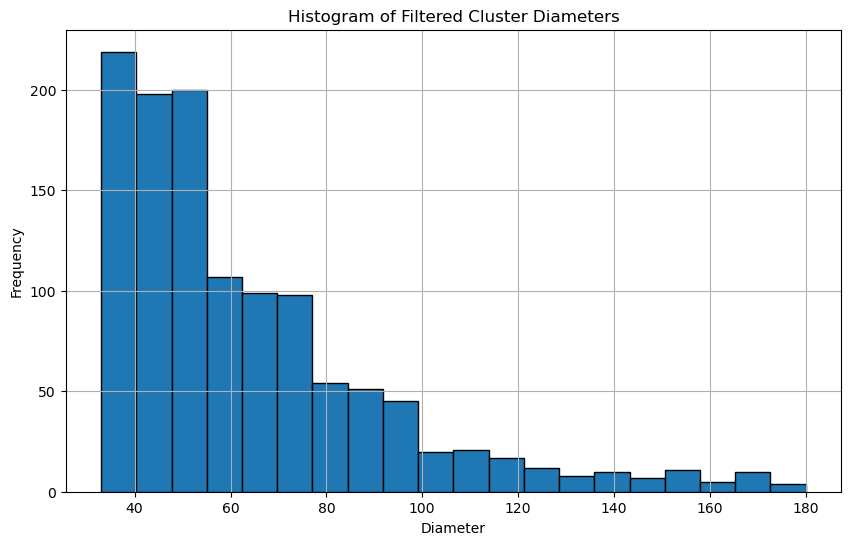

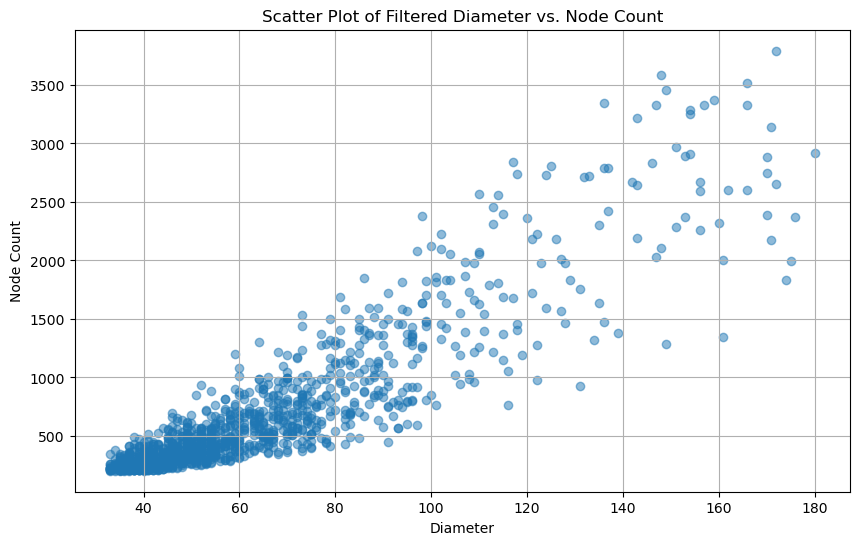

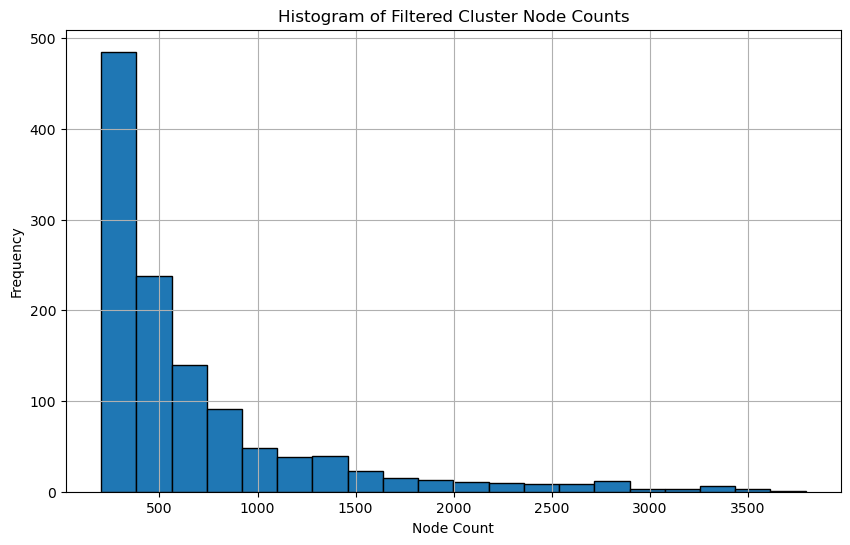

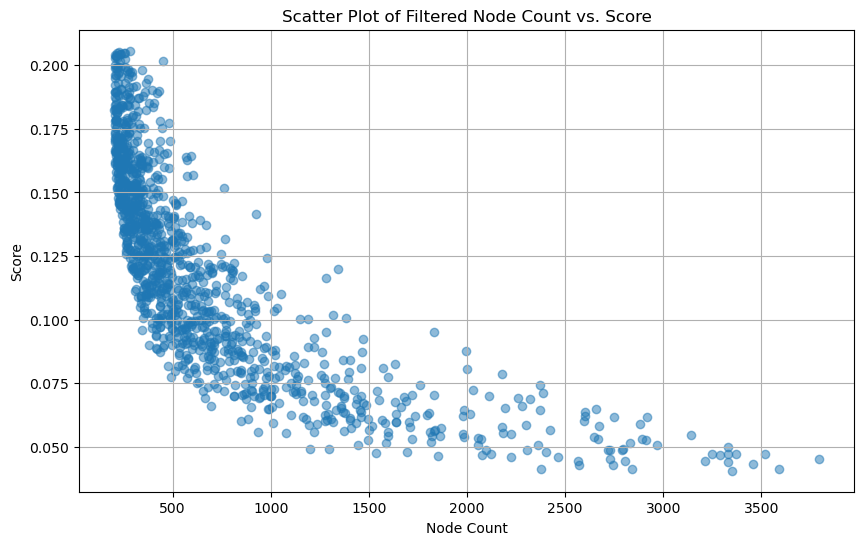

In [14]:
# Plot histogram of filtered scores
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['score'], bins=20, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Filtered Cluster Scores')
plt.grid(True)
plt.show()

# Plot scatter plot of filtered diameter vs. score
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['diameter'], filtered_df['score'], alpha=0.5)
plt.xlabel('Diameter')
plt.ylabel('Score')
plt.title('Scatter Plot of Filtered Diameter vs. Score')
plt.grid(True)
plt.show()

# Plot histogram of filtered diameters
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['diameter'], bins=20, edgecolor='black')
plt.xlabel('Diameter')
plt.ylabel('Frequency')
plt.title('Histogram of Filtered Cluster Diameters')
plt.grid(True)
plt.show()

# Plot scatter plot of filtered diameter vs. node_count
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['diameter'], filtered_df['node_count'], alpha=0.5)
plt.xlabel('Diameter')
plt.ylabel('Node Count')
plt.title('Scatter Plot of Filtered Diameter vs. Node Count')
plt.grid(True)
plt.show()

# Plot histogram of filtered node counts
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['node_count'], bins=20, edgecolor='black')
plt.xlabel('Node Count')
plt.ylabel('Frequency')
plt.title('Histogram of Filtered Cluster Node Counts')
plt.grid(True)
plt.show()

# Plot scatter plot of filtered node_count vs. score
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['node_count'], filtered_df['score'], alpha=0.5)
plt.xlabel('Node Count')
plt.ylabel('Score')
plt.title('Scatter Plot of Filtered Node Count vs. Score')
plt.grid(True)
plt.show()